In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import splitfolders

input_folder = r"C:\Users\ADMIN\Documents\Document\USTH\B3\Luan_tot_nghiep\dataset\mango leaf dataset"
output_folder = r"C:\Users\ADMIN\Documents\Document\USTH\B3\Luan_tot_nghiep\dataset\mango_leaf_split"

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2))


Copying files: 4000 files [00:02, 1496.67 files/s]


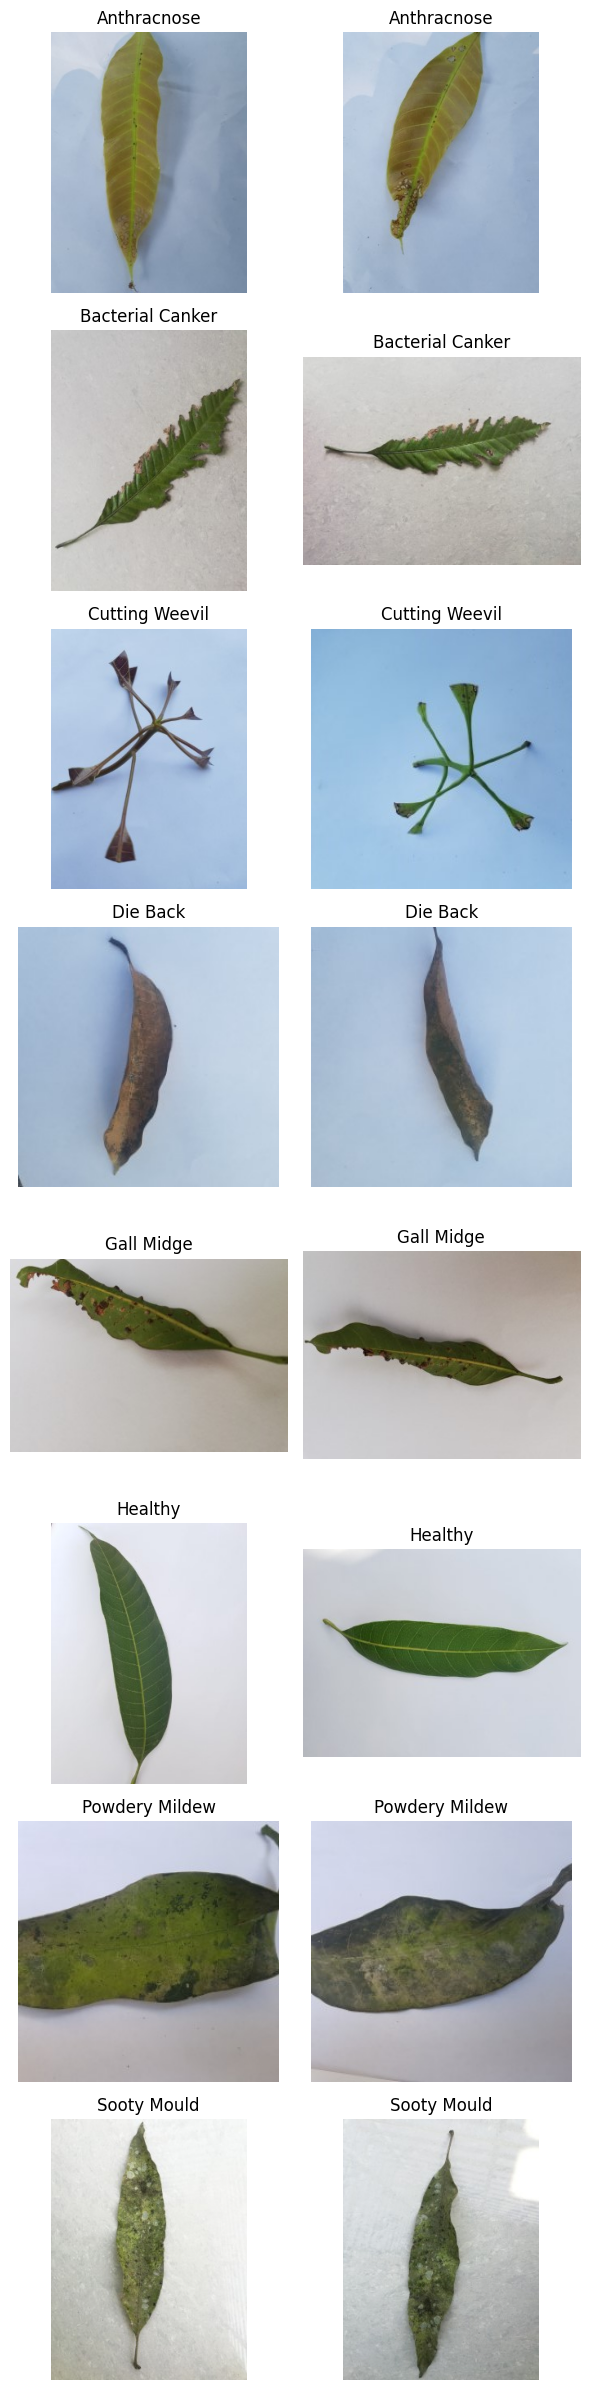

In [3]:
# Đường dẫn tới folder test sau khi chia
test_dir = r"C:\Users\ADMIN\Documents\Document\USTH\B3\Luan_tot_nghiep\dataset\mango_leaf_split\test"

# Load tập test
dataset = load_dataset("imagefolder", data_dir=test_dir)
ds = dataset['train']  # datasets chỉ có 1 key là 'train' nếu chỉ có 1 folder

# Tạo dictionary để lưu mỗi label 2 ảnh
label_imgs = {}
label_names = ds.features['label'].names  # tên các label

for sample in ds:
    label_id = sample['label']
    if label_id not in label_imgs:
        label_imgs[label_id] = []
    if len(label_imgs[label_id]) < 2:
        label_imgs[label_id].append(sample['image'])
    # Dừng khi đã đủ 2 ảnh cho mỗi label
    if all(len(v) == 2 for v in label_imgs.values()) and len(label_imgs) == len(label_names):
        break

# Plot
fig, axes = plt.subplots(len(label_names), 2, figsize=(6, 3*len(label_names)))
for i, label_id in enumerate(sorted(label_imgs.keys())):
    for j in range(2):
        axes[i, j].imshow(label_imgs[label_id][j])
        axes[i, j].set_title(label_names[label_id])
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()


In [4]:
from datasets import load_dataset

data_dir = r"C:\Users\ADMIN\Documents\Document\USTH\B3\Luan_tot_nghiep\dataset\mango_leaf_split"
dataset = load_dataset("imagefolder", data_dir=data_dir)

# Kết quả: dataset['train'] và dataset['test']
print(dataset)


Generating train split: 3200 examples [00:00, 12851.11 examples/s]
Generating validation split: 800 examples [00:00, 12454.60 examples/s]
Generating test split: 800 examples [00:00, 12202.90 examples/s]


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 800
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 800
    })
})


 Load Processor và Model
  

In [5]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

model_checkpoint = "DunnBC22/vit-base-patch16-224-in21k-Mango_leaf_Disease"
processor = AutoImageProcessor.from_pretrained(model_checkpoint)
model = AutoModelForImageClassification.from_pretrained(model_checkpoint)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Tiền xử lý ảnh với processor

In [6]:
def transform(example_batch):
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')
    inputs['label'] = example_batch['label']
    return inputs

prepared_ds = dataset.with_transform(transform)


TrainingArguments & Trainer 


 Khai báo compute_metrics

In [23]:
from sklearn.metrics import accuracy_score

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    return {"accuracy": accuracy_score(p.label_ids, preds)}


Khai báo TrainingArguments

In [24]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results-vit",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    evaluation_strategy="epoch",      # Đảm bảo đánh giá mỗi epoch
    logging_strategy="epoch",         # Ghi log mỗi epoch
    save_strategy="epoch",            # Lưu checkpoint mỗi epoch
    remove_unused_columns=False,
    report_to="none",                 # Đỡ warning trên notebook
)


c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Tạo lại Trainer với compute_metrics

In [25]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    compute_metrics=compute_metrics,      # RẤT QUAN TRỌNG
)


Reset lại modelmodel

In [29]:
model = AutoModelForImageClassification.from_pretrained(model_checkpoint)


Fine tuninging

In [30]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.035000,0.040494,0.987500
2,0.018000,0.002894,1.000000
3,0.001300,0.000964,1.000000
4,0.000800,0.000677,1.000000
5,0.000600,0.000512,1.000000
6,0.000500,0.000409,1.000000
7,0.000400,0.000342,1.000000
8,0.000300,0.000299,1.000000
9,0.000300,0.000273,1.000000
10,0.000300,0.000264,1.000000


TrainOutput(global_step=4000, training_loss=0.005739964546635747, metrics={'train_runtime': 1352.3472, 'train_samples_per_second': 23.663, 'train_steps_per_second': 2.958, 'total_flos': 2.5003360040193884e+18, 'train_loss': 0.005739964546635747, 'epoch': 10.0})

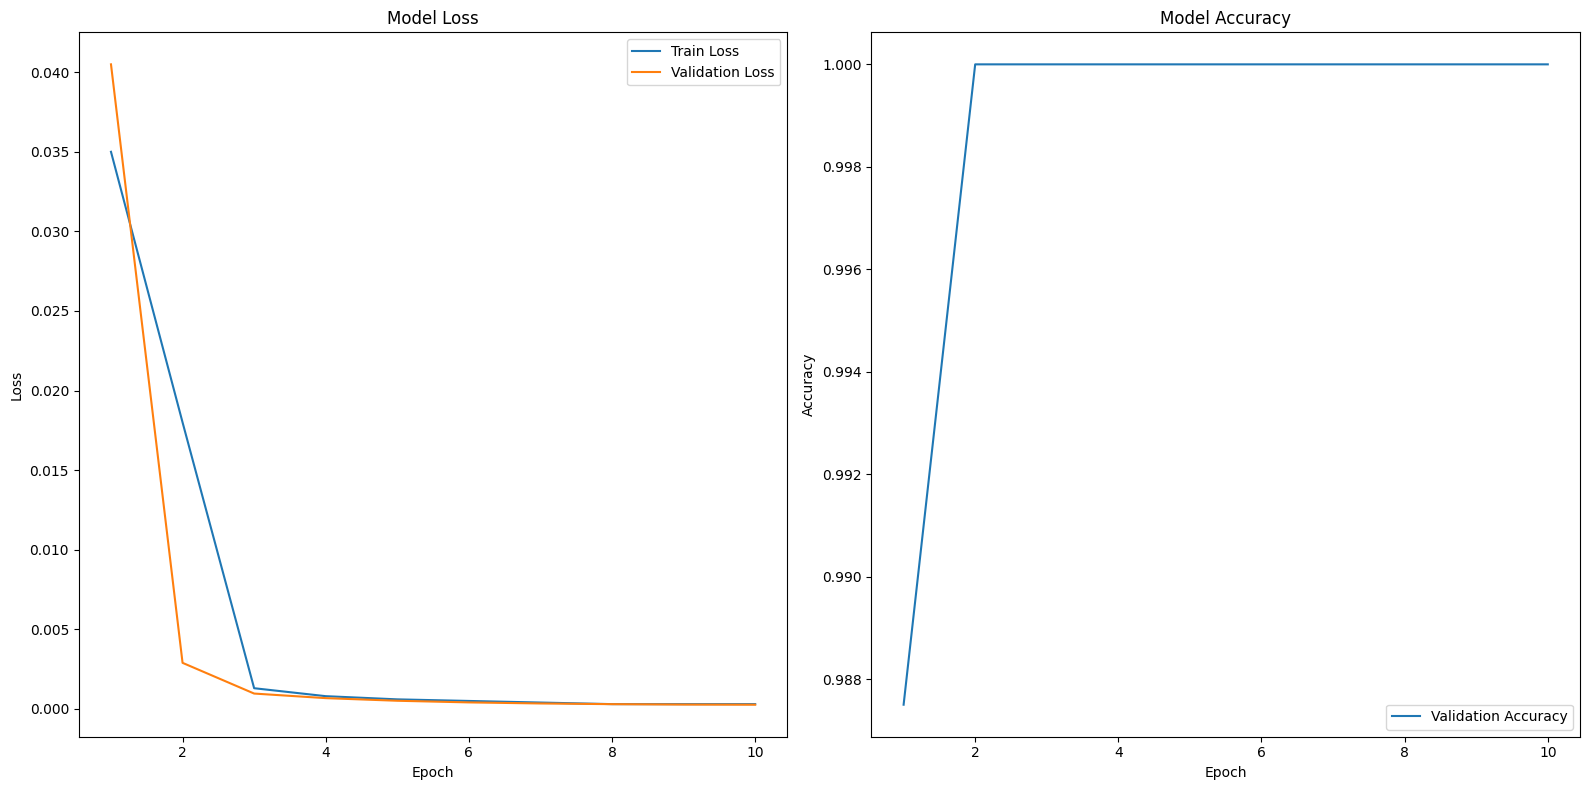

In [31]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

train_loss = [entry['loss'] for entry in logs if 'loss' in entry and 'eval_loss' not in entry]
eval_loss = [entry['eval_loss'] for entry in logs if 'eval_loss' in entry]
train_acc = [entry['accuracy'] for entry in logs if 'accuracy' in entry]
eval_acc = [entry['eval_accuracy'] for entry in logs if 'eval_accuracy' in entry]
epochs_loss = [entry['epoch'] for entry in logs if 'loss' in entry and 'eval_loss' not in entry]
epochs_eval = [entry['epoch'] for entry in logs if 'eval_loss' in entry]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(epochs_loss, train_loss, label='Train Loss')
ax[0].plot(epochs_eval, eval_loss, label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper right')

ax[1].plot(epochs_eval, eval_acc, label='Validation Accuracy')
if len(train_acc) == len(epochs_loss):
    ax[1].plot(epochs_loss, train_acc, label='Train Accuracy')
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.show()
